In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

2024-11-29 18:14:09.530409: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 18:14:09.634817: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-29 18:14:09.723736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732914849.807324    1462 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732914849.831307    1462 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 18:14:10.040380: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [20]:
gym.envs.registry

{'CartPole-v0': EnvSpec(id='CartPole-v0', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0),
 'CartPole-v1': EnvSpec(id='CartPole-v1', entry_point='gym.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1),
 'MountainCar-v0': EnvSpec(id='MountainCar-v0', entry_point='gym.envs.classic_control.mountain_car:MountainCarEnv', reward_threshold=-110.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='MountainCar', version=0),
 'Mounta

In [21]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
obs = env.reset()
print(obs)

(array([-0.00558664, -0.0253934 ,  0.04130986, -0.00168504], dtype=float32), {})


In [23]:
type(obs[0])

numpy.ndarray

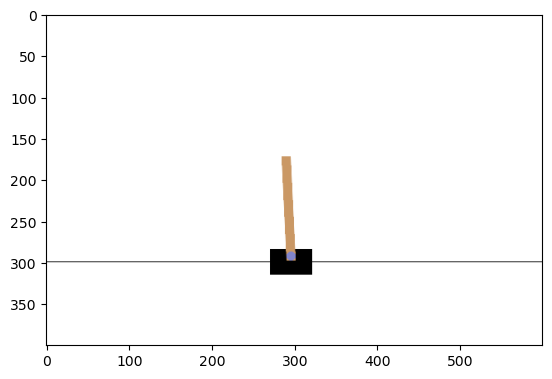

In [ ]:

plt.imshow(env.render())

In [5]:
env.action_space # Discrete(2) -> 0 or 1

Discrete(2)

In [6]:
action = 1
obs, reward, done, _, info = env.step(action)
print(obs) # obs[0] = position, obs[1] = velocity, obs[2] = angle, obs[3] = angular velocity

[-0.02797604  0.170798   -0.04813005 -0.34584746]


/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [7]:
reward

1.0

In [8]:
done

False

In [9]:
info

{}

In [10]:
env.close()

In [11]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

In [12]:
totals = []
# training loop
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()[0]
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, _, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [ ]:

print(f"Mean rewards: {np.mean(totals)}, std: {np.std(totals)}, min: {np.min(totals)}, max: {np.max(totals)}")

Mean rewards: 42.8, std: 9.024189714317846, min: 25.0, max: 66.0


# Trying with a neural network (Policy Gradient)

2024-11-20 15:02:55.525405: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 15:02:55.527091: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 15:02:55.531736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732125775.540745   28208 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732125775.543326   28208 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 15:02:55.552841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [15]:
n_inputs = 4

In [16]:
model = keras.models.Sequential([
    keras.layers.Dense(5, activation='elu', input_shape=[n_inputs]),
    keras.layers.Dense(1, activation='sigmoid')
])

/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1732125776.938919   28208 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis]) # predict the probability of going left
        action = (tf.random.uniform([1, 1]) > left_proba) # random action based on the probability
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32) # target probability
        loss = tf.reduce_mean(loss_fn(y_target, left_proba)) # loss function
    grads = tape.gradient(loss, model.trainable_variables) # compute the gradients
    obs, reward, done, _, info = env.step(int(action[0, 0].numpy())) # apply the action
    return obs, reward, done, grads

In [18]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    max_steps = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        current_max_steps = 0
        obs = env.reset()[0]
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                if step > current_max_steps:
                    current_max_steps = step
                break
        else: # executed if the loop ended without break
            current_max_steps = n_max_steps
        max_steps.append(current_max_steps)
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads, max_steps

In [19]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1): # iterate over the rewards in reverse order
        discounted[step] += discounted[step + 1] * discount_rate # add the discounted reward from the next step
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std for discounted_rewards in all_discounted_rewards]

In [20]:
discount_rewards([10,0,-50], discount_rate=0.8)

array([-22, -40, -50])

In [21]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

## Definindo Hiperparâmetros

In [22]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

### Optimizer and Loss Function

In [23]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

## Training loop

In [24]:
for iteration in range(n_iterations):
    all_rewards, all_grads, max_steps = play_multiple_episodes(env, n_episodes_per_update, n_max_steps, model, loss_fn)
    print(f"Iteration {iteration}:\n\tmean rewards = {np.mean([sum(rewards) for rewards in all_rewards])};\n\tmax steps = {np.max(max_steps)};\n\tmean steps = {np.mean(max_steps)}")
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)): # iterate over all trainable variables
        mean_grads = tf.reduce_mean([final_reward * all_grads[episode_index][step][var_index] # mean gradient for this variable
                                     for episode_index, final_rewards in enumerate(all_final_rewards)
                                     for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables)) # apply the gradients

Iteration 0:
	mean rewards = 20.4;
	max steps = 35;
	mean steps = 19.4
Iteration 1:
	mean rewards = 24.4;
	max steps = 46;
	mean steps = 23.4
Iteration 2:
	mean rewards = 25.2;
	max steps = 58;
	mean steps = 24.2
Iteration 3:
	mean rewards = 31.0;
	max steps = 108;
	mean steps = 30.0
Iteration 4:
	mean rewards = 17.8;
	max steps = 35;
	mean steps = 16.8
Iteration 5:
	mean rewards = 30.6;
	max steps = 52;
	mean steps = 29.6
Iteration 6:
	mean rewards = 24.3;
	max steps = 58;
	mean steps = 23.3
Iteration 7:
	mean rewards = 20.9;
	max steps = 35;
	mean steps = 19.9
Iteration 8:
	mean rewards = 30.2;
	max steps = 61;
	mean steps = 29.2
Iteration 9:
	mean rewards = 25.4;
	max steps = 37;
	mean steps = 24.4
Iteration 10:
	mean rewards = 34.6;
	max steps = 52;
	mean steps = 33.6
Iteration 11:
	mean rewards = 30.6;
	max steps = 64;
	mean steps = 29.6
Iteration 12:
	mean rewards = 25.0;
	max steps = 50;
	mean steps = 24.0
Iteration 13:
	mean rewards = 32.5;
	max steps = 73;
	mean steps = 31.5
I

# Crypto Environment

In [ ]:
from crypto_trading_env import CryptoTradingEnv

In [12]:
df = pd.read_parquet('../btc_hist_partitioned.parquet')
env = CryptoTradingEnv(dataset=df, initial_balance=1000, max_lose_percent=0.2)

In [13]:
action = 0
state, profit, done = env.step(action)
print(f"Step: {env.current_step}, Action: {action}, Profit: {profit}, Done: {done}\nState: {state}")

Step: 1, Action: 0, Profit: 1000.0, Done: False
State: Date             2019-01-03 00:00:00
Open                     3931.048584
High                     3935.685059
Low                        3826.2229
Close                    3836.741211
m_avg_7                  3874.556885
m_avg_25                 3874.556885
m_avg_99                 3874.556885
close_diff                  -0.02705
m_avg_7_diff               -0.004856
m_avg_25_diff              -0.004856
m_avg_99_diff              -0.004856
Name: 1, dtype: object


In [14]:
action = 2
state, profit, done = env.step(action)
print(f"Step: {env.current_step}, Action: {action}, Profit: {profit}, Done: {done}\nState: {state}")

Step: 2, Action: 2, Profit: 972.9502566367873, Done: False
State: Date             2019-01-04 00:00:00
Open                     3832.040039
High                      3865.93457
Low                       3783.85376
Close                    3857.717529
m_avg_7                  3870.347046
m_avg_25                 3870.347046
m_avg_99                 3870.347046
close_diff                  0.005467
m_avg_7_diff               -0.001087
m_avg_25_diff              -0.001087
m_avg_99_diff              -0.001087
Name: 2, dtype: object


In [15]:
action = 2
state, profit, done = env.step(action)
print(f"Step: {env.current_step}, Action: {action}, Profit: {profit}, Done: {done}\nState: {state}")

Step: 3, Action: 2, Profit: 978.2695922940552, Done: False
State: Date             2019-01-05 00:00:00
Open                     3851.973877
High                     3904.903076
Low                      3836.900146
Close                     3845.19458
m_avg_7                  3865.316553
m_avg_25                 3865.316553
m_avg_99                 3865.316553
close_diff                 -0.003246
m_avg_7_diff                 -0.0013
m_avg_25_diff                -0.0013
m_avg_99_diff                -0.0013
Name: 3, dtype: object


In [16]:
action = 1
state, profit, done = env.step(action)
print(f"Step: {env.current_step}, Action: {action}, Profit: {profit}, Done: {done}\nState: {state}")

Step: 4, Action: 1, Profit: 975.0939268044208, Done: False
State: Date             2019-01-06 00:00:00
Open                     3836.519043
High                     4093.297363
Low                      3826.513184
Close                    4076.632568
m_avg_7                  3900.535889
m_avg_25                 3900.535889
m_avg_99                 3900.535889
close_diff                  0.060189
m_avg_7_diff                0.009112
m_avg_25_diff               0.009112
m_avg_99_diff               0.009112
Name: 4, dtype: object


In [26]:
state.values[np.newaxis]

array([[Timestamp('2019-01-06 00:00:00'), 3836.51904296875,
        4093.29736328125, 3826.51318359375, 4076.632568359375,
        3900.535888671875, 3900.535888671875, 3900.535888671875,
        0.06018888861446059, 0.009111630433627838, 0.009111630433627838,
        0.009111630433627838]], dtype=object)

# Markov Decision Process

In [ ]:
env = gym.make('CartPole-v0', render_mode="rgb_array")
input_shape = [4]
n_outputs = 2

In [30]:
ql_model = keras.models.Sequential([
    keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(n_outputs)
])

/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        if state is None or state[np.newaxis] is None:
            raise ValueError("State is None")
            print(state, type(state))
        print(state, type(state))
        Q_values = ql_model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [32]:
from collections import deque

replay_buffer = deque(maxlen=2000)

In [33]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    if state is None:
        raise ValueError("State is None")
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, _, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [34]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = keras.losses.MeanSquaredError

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
        (1 - dones) * discount_factor * max_next_Q_values)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [35]:
for episode in range(600):
    obs = env.reset()
    if obs is None:
        raise ValueError("Initial observation is None")
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    if episode > 50:
        training_step(batch_size)

[-0.03167776 -0.23705247 -0.02054413  0.25118956] [[-0.03167776 -0.23705247 -0.02054413  0.25118956]] <class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[ 0.16140969 -0.03082385 -0.18133487 -0.2694256 ] [[ 0.16140969 -0.03082385 -0.18133487 -0.2694256 ]] <class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[ 0.00100953 -0.6225513   0.02415642  0.8478916 ] [[ 0.00100953 -0.6225513   0.02415642  0.8478916 ]] <class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/home/hugo/miniconda3/envs/postech/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[ 0.01280758  0.43294027 -0.01960069 -0.56773597] [[ 0.01280758  0.43294027 -0.01960069 -0.56773597]] <class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


TypeError: tuple indices must be integers or slices, not NoneType